In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-d3041bb6dcdf.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-d3041bb6dcdf.json


In [4]:
%load_ext google.cloud.bigquery

In [5]:
def plot_tweets_timeseries(df):
    day = df['day_of_tweet']
    num_tweets = df['num_tweets']
    num_unique_tweets = df['num_unique_tweets']

    plt.style.use('fivethirtyeight')
    figure = plt.figure(figsize=(15,5))
    plt.plot(day, num_tweets, label = 'Total tweets')
    plt.plot(day,num_unique_tweets, label = 'Unique tweets')

    plt.xlabel('Day of August 2014')
    plt.ylabel('Tweets')
    plt.legend()

    xticks = np.arange(1,32,1)
    plt.xticks(xticks)  

    ylocs, ylabels = plt.yticks()
    ylocs = [yloc for yloc in ylocs if yloc>= 0]
    ylabels = [str(int(loc/1e3)) + 'K' for loc in ylocs]
    plt.yticks(ylocs, ylabels)

    return(figure)


def plot_distributions(df, size=15, adj=0.1, dec=0):
    categories = df['categories']
    percentages = df['percentages']
    
    plt.style.use('fivethirtyeight')
    figure = plt.figure(figsize=(15,5))
    plt.bar(categories, percentages)

    plt.ylabel('Percentage of Tweets')

    plt.ylim(0.0,1.0)
    ylocs, ylabels = plt.yticks()
    ylocs = [yloc for yloc in ylocs if yloc>= 0]
    ylabels = [str(int(loc * 100)) + '%' for loc in ylocs]
    plt.yticks(ylocs, ylabels)
    
    for i, v in enumerate(percentages):
        if v > 0.25 * np.max(percentages):
            plt.text(i - adj, v / 2, str(round(v * 100, dec)) + '%', size = size)
        else:
            plt.text(i - adj, v + 0.01, str(round(v * 100, dec)) + '%', size = size)
    return(figure)

In [6]:
%%bigquery count_all_tweets
SELECT COUNT(*) AS n FROM tweets.all_tweets 

In [7]:
%%bigquery count_valid_tweets
SELECT COUNT(*) AS n FROM tweets.all_valid_tweets 

In [8]:
%%bigquery count_unique_valid_tweets
SELECT COUNT(DISTINCT(full_text)) AS n FROM tweets.all_valid_tweets 

In [9]:
count_all_tweets['n']

0    8500890
Name: n, dtype: int64

In [10]:
valid_categories = [
    'Available \nTweets',
    'Valid \nTweets',
    'Valid and Unique \nTweets'
    
]
valid_percentages = [
    float(count_all_tweets['n'] / count_all_tweets['n']),
    float(count_valid_tweets['n'] / count_all_tweets['n']),
    float(count_unique_valid_tweets['n'] / count_all_tweets['n'])    
]
valid_df = pd.DataFrame({'categories': valid_categories, 'percentages': valid_percentages})

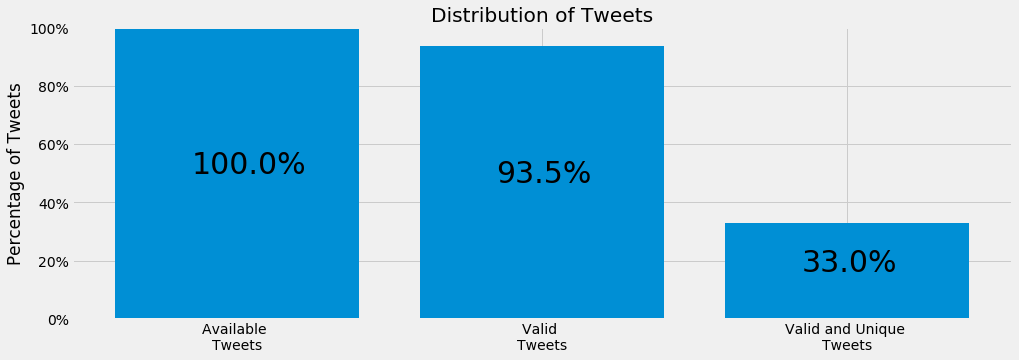

In [11]:
figure = plot_distributions(valid_df, size=30, adj=0.15, dec=1)
plt.title('Distribution of Tweets')
plt.show()

In [12]:
%%bigquery keywords_distribution
SELECT
    AVG(ferguson_ht) AS ferguson,
    AVG(michael_brown) AS michael_brown,
    AVG(other_murders_august) AS other_murders_august,
    AVG(eric_garner) AS eric_garner,
    AVG(blm) AS blm,
    AVG(other_murders_before) AS other_murders_before
FROM tweets.all_valid_tweets

In [13]:
keywords_distribution = keywords_distribution.T
keywords_distribution.columns = ['percentages']
keywords_distribution['categories'] = [
    '#Ferguson', '#MichaelBrown', 'Other murders \n(Aug)', 
    '#EricGarner', '#BLM', 'Other murders \n(before Aug)'
]

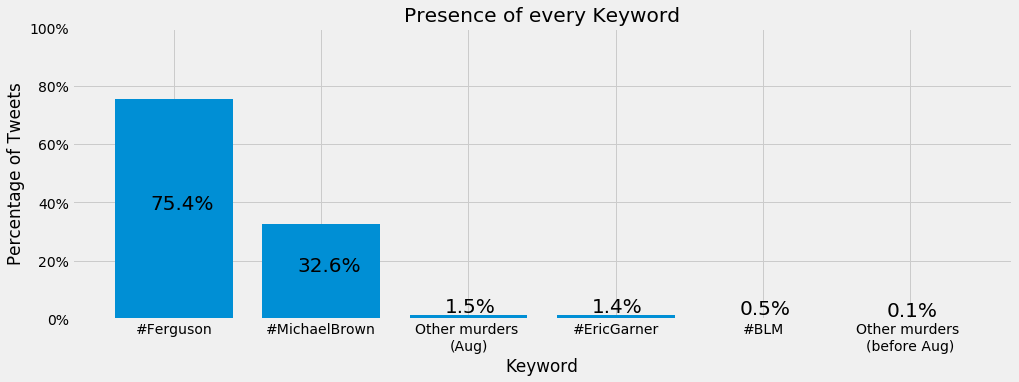

In [14]:
figure = plot_distributions(keywords_distribution, size=20, adj=0.16, dec=1)
plt.title('Presence of every Keyword')
plt.xlabel('Keyword')
plt.show()

In [15]:
%%bigquery ferg_mb_distr
SELECT
    AVG(IF(ferguson_ht = 1 AND michael_brown = 0, 1, 0)) AS only_ferguson,
    AVG(IF(ferguson_ht = 0 AND michael_brown = 1, 1, 0)) AS only_michael_brown,
    AVG(IF(ferguson_ht + michael_brown = 2, 1, 0)) AS both,
    AVG(IF(ferguson_ht + michael_brown = 0, 1, 0)) AS other
FROM tweets.all_valid_tweets

In [16]:
ferg_mb_distr = ferg_mb_distr.T
ferg_mb_distr.columns = ['percentages']
ferg_mb_distr['categories'] = [
    '#Ferguson but\nnot #MichaelBrown', '#MichaelBrown but \nnot #Ferguson', 
    '#Ferguson and\n #MichaelBrown', 'Neither #Ferguson \nor #MichaelBrown'
]

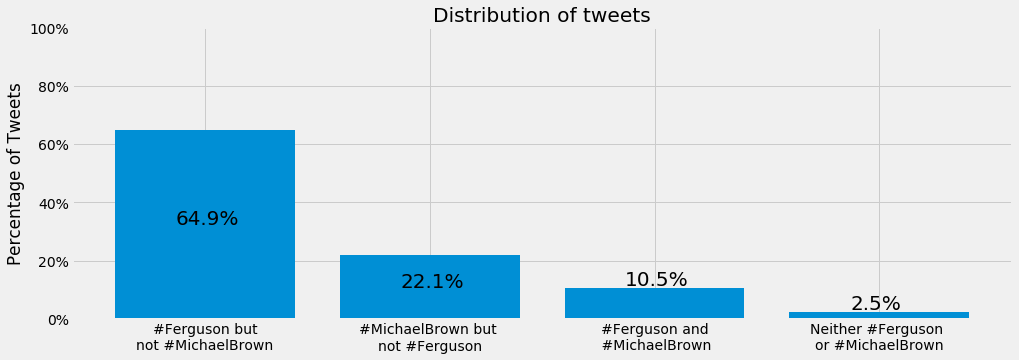

In [17]:
figure = plot_distributions(ferg_mb_distr, size=20, adj=0.13, dec=1)
plt.title('Distribution of tweets')
plt.show()

In [18]:
%%bigquery ferguson_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE ferguson_ht = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

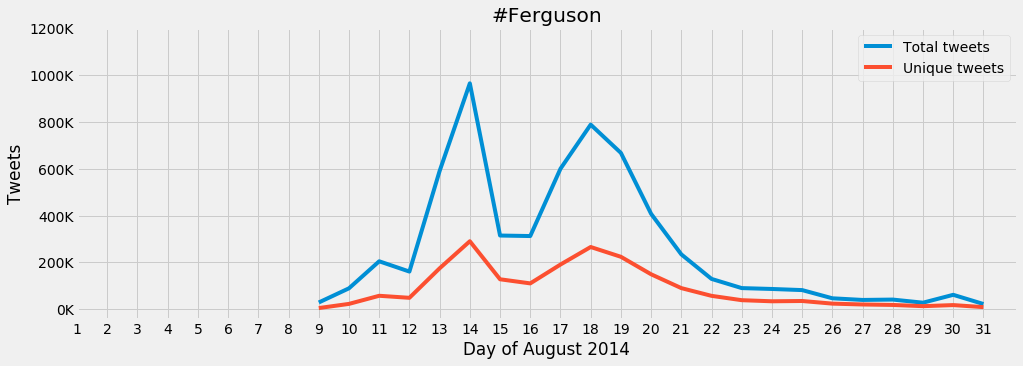

In [19]:
figure = plot_tweets_timeseries(ferguson_tweets)
plt.title('#Ferguson')
plt.show()

In [20]:
%%bigquery mikebrown_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE michael_brown = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

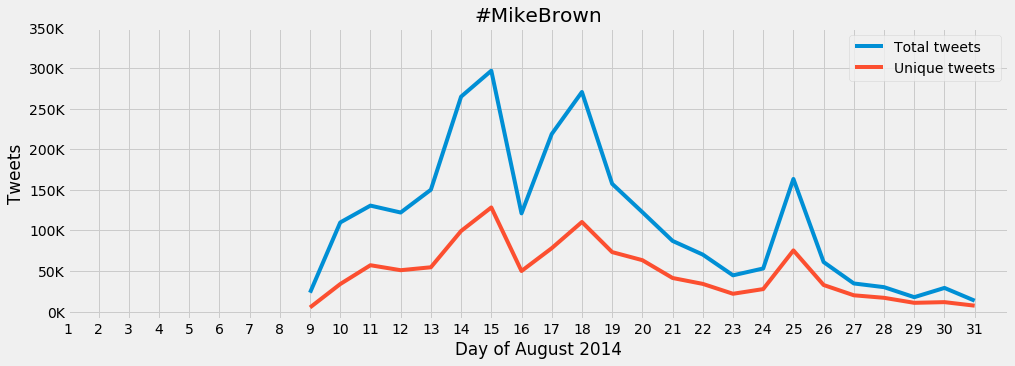

In [21]:
figure = plot_tweets_timeseries(mikebrown_tweets)
plt.title('#MikeBrown')
plt.show()

In [22]:
%%bigquery ericgarner_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE eric_garner = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

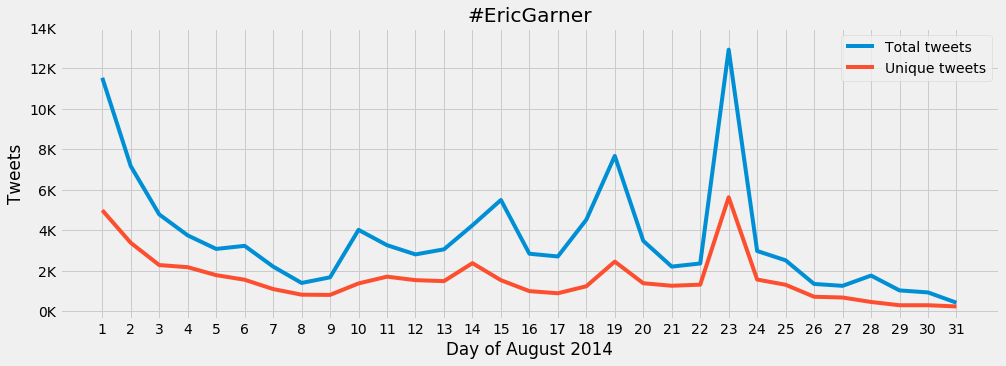

In [23]:
figure = plot_tweets_timeseries(ericgarner_tweets)
plt.title('#EricGarner')
plt.show()

In [24]:
%%bigquery blm_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE blm = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

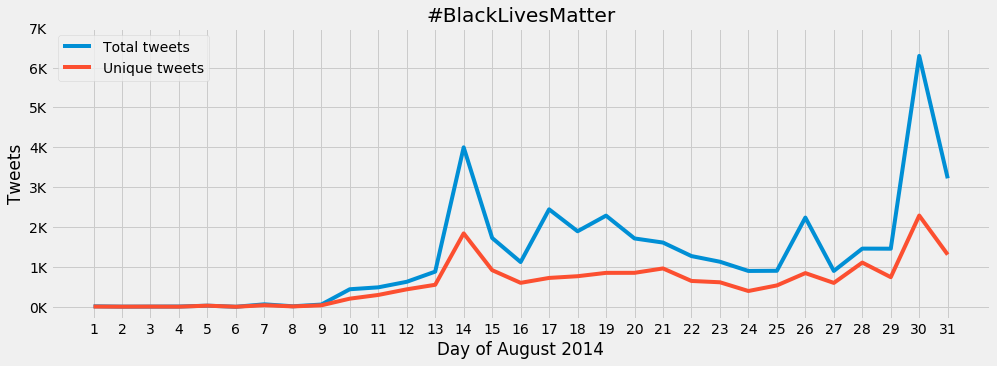

In [25]:
figure = plot_tweets_timeseries(blm_tweets)
plt.title('#BlackLivesMatter')
plt.show()

In [26]:
%%bigquery other_murders_august_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE other_murders_august = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

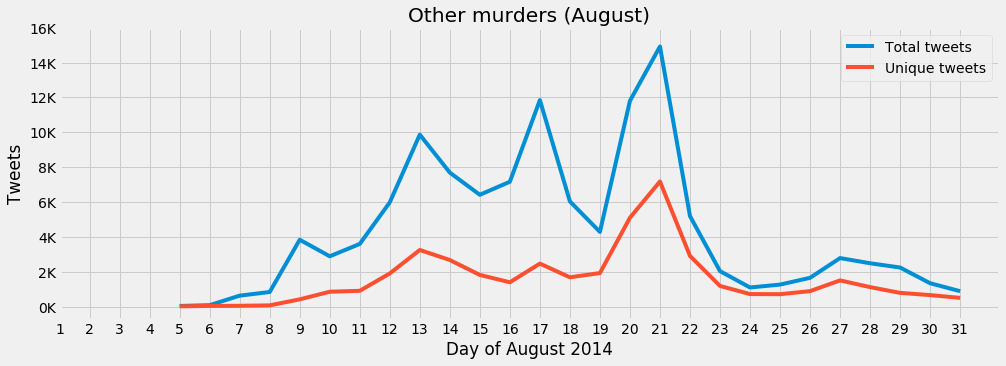

In [27]:
figure = plot_tweets_timeseries(other_murders_august_tweets)
plt.title('Other murders (August)')
plt.show()

In [28]:
%%bigquery other_murders_before_tweets
SELECT
  day_of_tweet,
  COUNT(*) AS num_tweets,
  COUNT(DISTINCT(full_text)) AS num_unique_tweets
FROM tweets.all_valid_tweets
WHERE other_murders_before = 1 
GROUP BY day_of_tweet
ORDER BY day_of_tweet

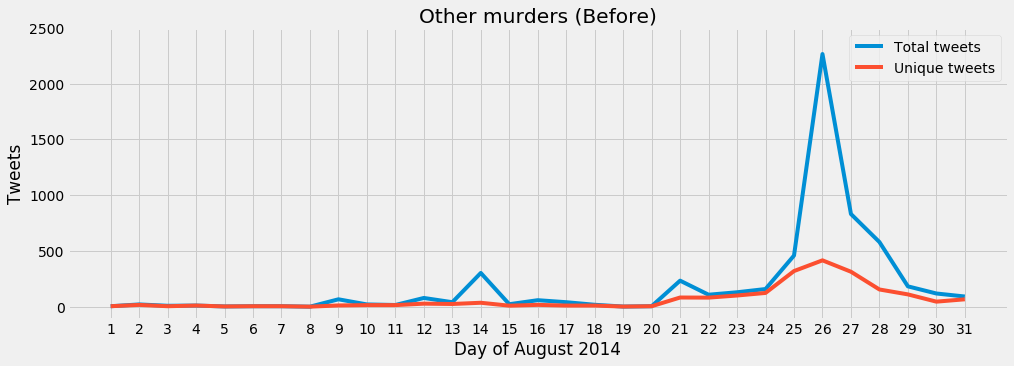

In [29]:
figure = plot_tweets_timeseries(other_murders_before_tweets)
plt.title('Other murders (Before)')
ylocs, ylabels = plt.yticks()
ylabels = [str(int(loc)) for loc in ylocs]
plt.yticks(ylocs, ylabels)
plt.show()